In [1]:
import pandas as pd
import numpy as np
import warnings
import os
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
# Load the data
base_dir = r"C:\Users\arushi\OneDrive\Desktop\data_fol\15min_data\adanient_data"
df_spot = pd.read_csv(os.path.join(base_dir, "adanient_spot_data.csv"))
df_spot = df_spot.drop(columns=['Unnamed: 0'])

# Calculate EMA for high and low prices
ema_span = 14
df_spot['ema_high'] = df_spot['high'].ewm(span=ema_span, adjust=False).mean().round(2)
df_spot['ema_low'] = df_spot['low'].ewm(span=ema_span, adjust=False).mean().round(2)

# Initialize 'signal' column with 0
df_spot['signal'] = 0

# Iterate through the DataFrame
for i in range(len(df_spot)):
    if df_spot['close'].iloc[i] > df_spot['ema_high'].iloc[i]:
        df_spot.at[i, 'signal'] = 'BUY'
    elif df_spot['close'].iloc[i] < df_spot['ema_low'].iloc[i]:
        df_spot.at[i, 'signal'] = 'SELL'

# Apply forward fill to propagate the last valid observation forward
df_spot['signal'] = df_spot['signal'].replace(0, method='ffill')

# Shift the 'signal' column by 1 to move the signals to the next day
df_spot['signal'] = df_spot['signal'].shift(1)

# Load future data
df_future = pd.read_csv(os.path.join(base_dir, "adanient_future_data.csv"))

# Initialize the filtered DataFrame
filtered_df = pd.DataFrame(columns=['Trade', 'Entry_date', 'Entry_time', 'Entry_price'])

# Iterate through the spot DataFrame to match signals with future data
for i in range(len(df_spot)):
    if df_spot['signal'].iloc[i] == 'BUY':
        date = df_spot['date'].iloc[i]
        time = df_spot['time'].iloc[i]
        # Search for the same date and time in future data
        temp = df_future[(df_future['date'] == date) & (df_future['time'] == time)]
        if not temp.empty:
            row = {
                'Trade': 'BUY',
                'Entry_date': date,
                'Entry_time': time,
                'Entry_price': temp['open'].values[0]
            }
            filtered_df = pd.concat([filtered_df, pd.DataFrame([row])], ignore_index=True)

    elif df_spot['signal'].iloc[i] == 'SELL':
        date = df_spot['date'].iloc[i]
        time = df_spot['time'].iloc[i]
        # Search for the same date and time in future data
        temp = df_future[(df_future['date'] == date) & (df_future['time'] == time)]
        if not temp.empty:
            row = {
                'Trade': 'SELL',
                'Entry_date': date,
                'Entry_time': time,
                'Entry_price': temp['open'].values[0]
            }
            filtered_df = pd.concat([filtered_df, pd.DataFrame([row])], ignore_index=True)
print(filtered_df)

      Trade  Entry_date Entry_time  Entry_price
0       BUY  2018-10-10   10:15:00       137.55
1       BUY  2018-10-10   10:30:00       138.75
2       BUY  2018-10-10   10:45:00       138.25
3       BUY  2018-10-10   11:00:00       138.80
4       BUY  2018-10-10   11:15:00       139.60
...     ...         ...        ...          ...
32906   BUY  2024-02-29   14:15:00      3253.55
32907   BUY  2024-02-29   14:30:00      3253.95
32908   BUY  2024-02-29   14:45:00      3260.00
32909   BUY  2024-02-29   15:00:00      3263.50
32910   BUY  2024-02-29   15:15:00      3277.55

[32911 rows x 4 columns]


In [2]:
# Define takeprofit and stoploss multipliers
takeprofit_multiplier = 1.05
stoploss_multiplier = 0.95


# Update the DataFrame to calculate takeprofit_price and stoploss_price where they are NaN

for i in range(len(filtered_df)):
    if filtered_df['Trade'].iloc[i] == 'BUY':
        filtered_df.at[i, 'takeprofit_price'] = filtered_df['Entry_price'].iloc[i] * takeprofit_multiplier
        filtered_df.at[i, 'stoploss_price'] = filtered_df['Entry_price'].iloc[i] * stoploss_multiplier
    elif filtered_df['Trade'].iloc[i] == 'SELL':
        filtered_df.at[i, 'takeprofit_price'] = filtered_df['Entry_price'].iloc[i] * stoploss_multiplier
        filtered_df.at[i, 'stoploss_price'] = filtered_df['Entry_price'].iloc[i] * takeprofit_multiplier

# Display the updated DataFrame
print(filtered_df)

      Trade  Entry_date Entry_time  Entry_price  takeprofit_price  \
0       BUY  2018-10-10   10:15:00       137.55          144.4275   
1       BUY  2018-10-10   10:30:00       138.75          145.6875   
2       BUY  2018-10-10   10:45:00       138.25          145.1625   
3       BUY  2018-10-10   11:00:00       138.80          145.7400   
4       BUY  2018-10-10   11:15:00       139.60          146.5800   
...     ...         ...        ...          ...               ...   
32906   BUY  2024-02-29   14:15:00      3253.55         3416.2275   
32907   BUY  2024-02-29   14:30:00      3253.95         3416.6475   
32908   BUY  2024-02-29   14:45:00      3260.00         3423.0000   
32909   BUY  2024-02-29   15:00:00      3263.50         3426.6750   
32910   BUY  2024-02-29   15:15:00      3277.55         3441.4275   

       stoploss_price  
0            130.6725  
1            131.8125  
2            131.3375  
3            131.8600  
4            132.6200  
...               ...  
329

In [3]:
# Assuming filtered_df and df_future are already defined and have the necessary columns
filtered_df['exit_date'] = None
filtered_df['exit_time'] = None
filtered_df['exit_price'] = 0.0
filtered_df['trade_statement'] = None

# Create a lookup for entry prices based on date and time
entry_price_lookup = df_future.set_index(['date', 'time'])['open'].to_dict()

# Process the initial rows
for idx, row in filtered_df.iterrows():
    entry_date = row['Entry_date']
    entry_time = row['Entry_time']
    trade_type = row['Trade']
    
    # Get the entry price
    entry_key = (entry_date, entry_time)
    entry_price = entry_price_lookup.get(entry_key, None)
    if entry_price is not None:
        filtered_df.at[idx, 'Entry_price'] = entry_price

    # Determine exit conditions
    condition = (df_future['date'] >= entry_date) & (df_future['time'] > entry_time)
    for idx_future, row_future in df_future[condition].iterrows():
        if trade_type == 'BUY':
            if row_future['high'] >= row['takeprofit_price']:
                filtered_df.at[idx, 'exit_date'] = row_future['date']
                filtered_df.at[idx, 'exit_time'] = row_future['time']
                filtered_df.at[idx, 'exit_price'] = row['takeprofit_price']
                filtered_df.at[idx, 'trade_statement'] = 'Take Profit'
                break
            elif row_future['low'] <= row['stoploss_price']:
                filtered_df.at[idx, 'exit_date'] = row_future['date']
                filtered_df.at[idx, 'exit_time'] = row_future['time']
                filtered_df.at[idx, 'exit_price'] = row['stoploss_price']
                filtered_df.at[idx, 'trade_statement'] = 'Stop Loss'
                break
        elif trade_type == 'SELL':
            if row_future['low'] <= row['takeprofit_price']:
                filtered_df.at[idx, 'exit_date'] = row_future['date']
                filtered_df.at[idx, 'exit_time'] = row_future['time']
                filtered_df.at[idx, 'exit_price'] = row['takeprofit_price']
                filtered_df.at[idx, 'trade_statement'] = 'Take Profit'
                break
            elif row_future['high'] >= row['stoploss_price']:
                filtered_df.at[idx, 'exit_date'] = row_future['date']
                filtered_df.at[idx, 'exit_time'] = row_future['time']
                filtered_df.at[idx, 'exit_price'] = row['stoploss_price']
                filtered_df.at[idx, 'trade_statement'] = 'Stop Loss'
                break

    # Check for signal change if no exit condition is met
    if pd.isnull(filtered_df.at[idx, 'exit_date']):
        for idx_future in range(idx + 1, len(filtered_df)):
            if filtered_df.at[idx_future, 'Trade'] != trade_type:
                filtered_df.at[idx, 'exit_date'] = filtered_df.at[idx_future, 'Entry_date']
                filtered_df.at[idx, 'exit_time'] = filtered_df.at[idx_future, 'Entry_time']
                filtered_df.at[idx, 'exit_price'] = filtered_df.at[idx_future, 'Entry_price']
                filtered_df.at[idx, 'trade_statement'] = 'Signal Change'
                break

# Remove rows where the entry date and time are less than the previous row's exit date and time
previous_exit_date = None
previous_exit_time = None
rows_to_keep = []

for idx, row in filtered_df.iterrows():
    if previous_exit_date is not None and previous_exit_time is not None:
        if (row['Entry_date'] < previous_exit_date) or (row['Entry_date'] == previous_exit_date and row['Entry_time'] < previous_exit_time):
            continue
    
    rows_to_keep.append(idx)
    previous_exit_date = row['exit_date']
    previous_exit_time = row['exit_time']

filtered_df = filtered_df.loc[rows_to_keep]
# Drop rows where 'Exit Date', 'Exit Time', or 'Exit Price' is None or NaN
filtered_df = filtered_df.dropna(subset=['exit_date', 'exit_time', 'exit_price'])
print(filtered_df.head())  # Display the first 50 rows to see the result
#filtered_df.to_csv('filtered_trades.csv', index=False)  # Save the DataFrame to a CSV file


   Trade  Entry_date Entry_time  Entry_price  takeprofit_price  \
0    BUY  2018-10-10   10:15:00       137.55          144.4275   
20   BUY  2018-10-10   15:15:00       142.40          149.5200   
24  SELL  2018-10-11   10:00:00       138.30          131.3850   
65   BUY  2018-10-12   14:00:00       144.30          151.5150   
93   BUY  2018-10-15   14:45:00       151.05          158.6025   

    stoploss_price   exit_date exit_time  exit_price trade_statement  
0         130.6725  2018-10-10  15:15:00    144.4275     Take Profit  
20        135.2800  2018-10-11  10:00:00    138.3000   Signal Change  
24        145.2150  2018-10-12  14:00:00    145.2150       Stop Loss  
65        137.0850  2018-10-15  14:45:00    151.5150     Take Profit  
93        143.4975  2018-10-16  15:00:00    158.6025     Take Profit  


In [4]:

# Initialize mfe% and mae% columns
filtered_df['mfe%'] = 0.0
filtered_df['mae%'] = 0.0

# Add date_time column to df_future for filtering
df_future['date_time'] = pd.to_datetime(df_future['date'] + ' ' + df_future['time'])

for idx, row in filtered_df.iterrows():
    entry_date = row['Entry_date']
    entry_time = row['Entry_time']
    exit_date = row['exit_date']
    exit_time = row['exit_time']
    trade_type = row['Trade']

    # Create timestamp for entry and exit points
    entry_date_time = pd.Timestamp(f"{entry_date} {entry_time}")
    exit_date_time = pd.Timestamp(f"{exit_date} {exit_time}")

    # Filter df_future based on date_time range
    condition = (df_future['date_time'] >= entry_date_time) & (df_future['date_time'] <= exit_date_time)
    temp = df_future[condition]

    if not temp.empty:
        if trade_type == 'BUY':
            mfe = temp['high'].max()
            mae = temp['low'].min()
            # Calculate mfe% and mae%
            filtered_df.at[idx, 'mfe%'] = round((((mfe - row['Entry_price']) / row['Entry_price']) * 100), 2)
            filtered_df.at[idx, 'mae%'] = round((((mae - row['Entry_price']) / row['Entry_price']) * 100), 2)
        elif trade_type == 'SELL':
            mfe = temp['low'].min()
            mae = temp['high'].max()
            # Calculate mfe% and mae%
            filtered_df.at[idx, 'mfe%'] = round((((row['Entry_price'] - mfe) / row['Entry_price']) * 100), 2)
            filtered_df.at[idx, 'mae%'] = round((((row['Entry_price'] - mae) / row['Entry_price']) * 100), 2)
    else:
        print(f"No data found between {entry_date_time} and {exit_date_time} for index {idx}.")

In [5]:
#################### Calculate the total profit/loss ####################
filtered_df['pnl'] = 0.0
for idx, row in filtered_df.iterrows():
    if row['Trade'] == 'BUY':
        filtered_df.at[idx, 'pnl'] = row['exit_price'] - row['Entry_price']
    elif row['Trade'] == 'SELL':
        filtered_df.at[idx, 'pnl'] = row['Entry_price'] - row['exit_price']

# Calculate the cummulative sum of the 'pnl' column
filtered_df['cumulative_pnl'] = filtered_df['pnl'].cumsum()
# Print the last value of cumulative_pnl
print(f"Final Cumulative PnL: {filtered_df['cumulative_pnl'].iloc[-1]}")
# Drawdown calculation 
filtered_df['drawdown'] = filtered_df['cumulative_pnl'] - filtered_df['cumulative_pnl'].cummax()
# Calculate the maximum drawdown
max_drawdown = filtered_df['drawdown'].min()
print(f"Maximum Drawdown: {max_drawdown}")


# Combine Entry_date and Entry_time into a single datetime column
filtered_df['Entry_datetime'] = pd.to_datetime(filtered_df['Entry_date'] + ' ' + filtered_df['Entry_time'])



Final Cumulative PnL: 5884.445000000003
Maximum Drawdown: -325.8475000000003


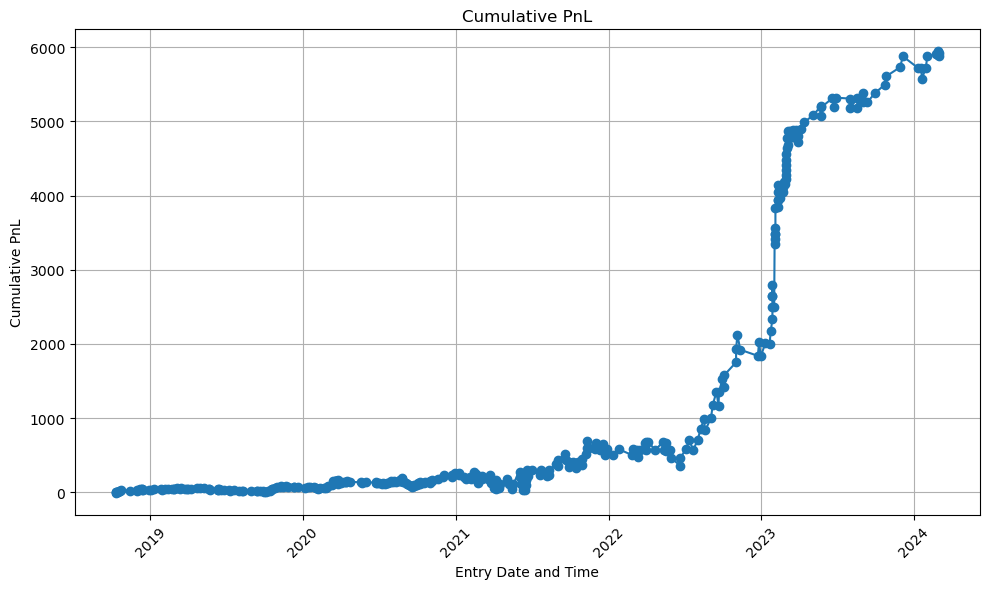

In [6]:
# Plotting the cumulative PnL
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Entry_datetime'], filtered_df['cumulative_pnl'], marker='o')
plt.title('Cumulative PnL')
plt.xlabel('Entry Date and Time')
plt.ylabel('Cumulative PnL')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
############################### directory to save the final results ###############################
# Drop unnecessary columns
filtered_df = filtered_df.drop(columns=['Entry_datetime'])

final_dir = r"C:\Users\arushi\Desktop\results\fish_strategy\colpal_results"
filtered_df.to_csv(os.path.join(final_dir, "colpal_trades.csv"), index=False)